###  Photosynthetic Electron Transport Chain mathematical model (version from 2014)
With this Notebook you can reproduce the results presented in 

Oliver Ebenhöh, Geoffrey Fucile, Giovanni Finazzi, Jean‐David Rochaix and Michel Goldschmidt‐Clermont (2014)
"Short-term acclimation of the photosynthetic electron transfer chain to changing light: a mathematical model"
*Phil Trans Roy Soc B* 369 doi:10.1098/rstb.2013.0223

The mathematical model of the photosynthetic electron transport chain has been implemented using the modelbase1.0 software developed at the University of Dusseldorf.

#### The model has been implemented using the modelbase1.0 version

In [1]:
# I want to have my figures active here (e.g., zoom into my plots)
%matplotlib notebook 

In [2]:
from modelbase.ode import Model, Simulator

import numpy as np
import matplotlib.pyplot as plt

Could not find GLIMDA.


## Create the model

I start with defining the compound list, as this is how I am thinking about model's structure: state variabels that describe the dynamics od the system.

In [3]:
variables = [
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "E",
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "Dd" # fraction of diadinoxanthin (Ddx) as epoxidised pigment
]

Next I pass the dictionary/dictionaries of parameters

In [4]:
p = {
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 25., # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 60., # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Xtot": 1.0,

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e7, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,

     # ATP and NADPH parameters
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 0.10, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kEpox": 0.04,
    "kDeepox": 0.004,
    "KphSatZ": 6.3,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 500.,
    "Toff": 1800,
    "dT": 120,
    
    "gamma": 2.,
    "kActATPase": 0.001,        # paramter relating the rate constant of activation of the ATPase in the light
    'kDeactATPase': 0.0002, 
    }


### Here we define the model object

In [5]:
# modelbase 0.4.0
m = Model(parameters=p, compounds=variables)

In [6]:
m.get_compounds()

['PQ', 'PC', 'Fd', 'E', 'ATP', 'NADPH', 'H', 'Dd']

From now on we will be adding various components to the model, such as derived parameters, that can be calculated from the provided parameters, derived variables, which can be calculated from other variables and reactions.

In [7]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [8]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (3.125e4 * 10 **(-x))



def calculate_pH(H):
    "assumed bigger lumen by changing the volume"
    return -np.log10(H*3.2e-5)

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

In [9]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def xcycmoiety(Dd, Xtot):
    return [Xtot - Dd]

m.add_algebraic_module(
    module_name = "X_am",
    function = xcycmoiety,
    compounds = ["Dd"],
    derived_compounds = ["Dt"],
    parameters = ["Xtot"])

def Quencher(Dt, gamma):
    """rate of quenching (kH = kH0 + kH*Dt)
    
    accepts: 
    Pr: fraction of non-protonated PsbS protein
    V: fraction of Violaxanthin
    """       
    #Q = gamma0 * (7.8-pH(H)) * Dt 
    Q = gamma * Dt

    return Q

m.add_algebraic_module(
    module_name = "Quencher",
    function = Quencher,
    compounds = ["Dt"],
    derived_compounds = ["Q"],
    parameters = ["gamma"])


def ps2states(Pox, PQred, Q, light, PSIItot, k2, kF, _kH, kH0, Keq_PQred, kPQred):
    """Calculates the states of photosystem II
    
    accepts:
    P: reduced fraction of PQ pool (PQH2)
    Q: Quencher
    
    returns:
    B: array of PSII states
    """
    
    Bs = []
    b0 = (light + kPQred*PQred/Keq_PQred)
    b1 = (kH0 + _kH * Q + kF)
    b2 = kH0 + _kH * Q + kF + k2
    
    for Pox,b0,b1,b2 in zip(Pox,b0,b1,b2):
        A = np.array([
        [-b0,        b1,         kPQred*Pox,                0], #B0
        [light,     -b2,         0,                         0], #B1
        [0,         0,          light,                   -b1], #B3
        [1,          1,          1,                         1]
        ])
        
        b = np.array([0,0,0,PSIItot])
        B0,B1,B2,B3 = np.linalg.solve(A,b)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["pfd", "PSIItot", "k2", "kF", "kH", "kH0", "Keq_PQred", "kPQred"],
)

def ps1states(PC, PCred, Fd, Fdred, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = pfd

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(B0, B2, Q, k2, kF, kH, kH0):
    fluo = (kF * B0) / (kF + kH0 + k2 + kH * Q) + (kF * B2) / (kF + kH0+ kH * Q)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["B0", "B2", "Q"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [10]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, pfd):
    """ reaction rate constant for open PSI """
    L = 0.5 * pfd
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1"],
    parameters=["pfd"],
    reversible=True,
)


m.add_algebraic_module(
    module_name = "L",
    function = lambda X, PFD: PFD ,
    compounds = ["PQ"],
    derived_compounds = ["L"],
    parameters = ['pfd'])

In [11]:
###############################################################################
# Reaction rates
###############################################################################

def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

   
    
def vATPactivity(E, light,  kActATPase,  kDeactATPase):
    """Activation of ATPsynthase by light"""
    switch = light > 0.1
    v = kActATPase * switch * (1 - E) - kDeactATPase * (1-switch) * E
    return v

    
m.add_reaction(
        rate_name = "vATPactivity",
        function = vATPactivity,
        dynamic_variables = ["E"],
        stoichiometry = {"E":1},
        parameters = ["pfd",  "kActATPase",  "kDeactATPase"]
)


def vATPsynthase(E, ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = E**5 * kATPsynth * (ADP - ATP / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1, "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["E", "ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT"],
    reversible=True,
)

def vATPconsumption(A, kATPcons):
        v = kATPcons * A
        return v
    
m.add_reaction(
    rate_name='vATPconsumption',
    function=vATPconsumption,
    stoichiometry= {"ATP": -1},
    parameters=["kATPcons"],
    reversible=False,
)


def vNADPHconsumption(N, kNADPHcons):
        v = kNADPHcons * N
        return v
    
m.add_reaction(
    rate_name='vNADPHconsumption',
    function=vNADPHconsumption,
    stoichiometry= {"NADPH": -1},
    parameters=["kNADPHcons"],
    reversible=False,
)

def vXcyc(V, H, NADPH, NADPtot, nH, KphSatZ, kDeepoxV, kEpoxZ, Xtot):
    """Xanthophyll cycle"""
    
    a = H**nH / (H**nH + calculate_pHinv(KphSatZ)**nH)
    v = kDeepoxV * a * V - kEpoxZ * (Xtot - V) * NADPH**nH / (NADPH**nH + (0.05*NADPtot)**nH) 
    return v


m.add_reaction(
        rate_name = "vXcyc",
        function = vXcyc,
        dynamic_variables = ['Dd','H', 'NADPH'],
        stoichiometry = {"Dd": -1},
        parameters = ["NADPtot", "nH", "KphSatZ", "kDeepox",
                      "kEpox", "Xtot"])

<IPython.core.display.Javascript object>


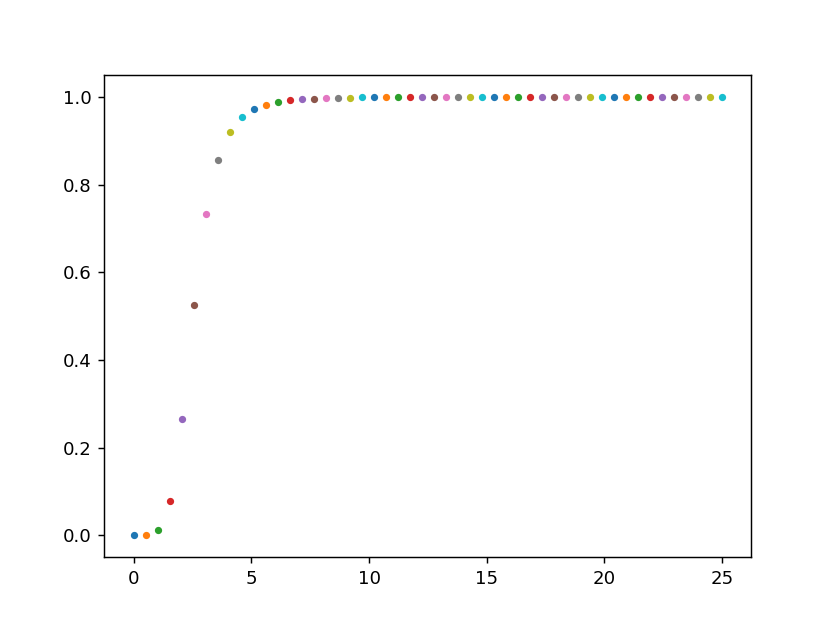

In [12]:
plt.figure()
for NADPH in np.linspace(0, p['NADPtot']):
    plt.plot(NADPH, NADPH**5 / (NADPH**5 + (0.1*p['NADPtot'])**5), '.')

To compare now the implemented model with the differential equations I am checking the stoichiometric matrix

In [13]:
m.get_stoichiometric_matrix()

array([[ 0.        , -1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.        ,
         2.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.04666667,  0.04      ,  0.        ,
         0.        , -0.01      ,  0.        ,  0.        ,  0.02      ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        , -1.        ,  0.        ,  0.        ,
         0.   

Ok, I have no idea what was the order of the reaction rates. Fortunately, there is this magic function `m.get_stoichiometric_df()`. How neat is that?

In [14]:
m.get_stoichiometric_df()

vATPactivity  vATPconsumption  vATPsynthase  vB6f  vCyc  vFNR  vLeak  \
ATP             0.0             -1.0      1.000000  0.00   0.0   0.0   0.00   
Dd              0.0              0.0      0.000000  0.00   0.0   0.0   0.00   
E               1.0              0.0      0.000000  0.00   0.0   0.0   0.00   
Fd              0.0              0.0      0.000000  0.00   2.0   2.0   0.00   
H               0.0              0.0     -0.046667  0.04   0.0   0.0  -0.01   
NADPH           0.0              0.0      0.000000  0.00   0.0   1.0   0.00   
PC              0.0              0.0      0.000000 -2.00   0.0   0.0   0.00   
PQ              0.0              0.0      0.000000  1.00  -1.0   0.0   0.00   

       vNADPHconsumption  vPS1  vPS2  vXcyc  
ATP                  0.0   0.0  0.00    0.0  
Dd                   0.0   0.0  0.00   -1.0  
E                    0.0   0.0  0.00    0.0  
Fd                   0.0  -1.0  0.00    0.0  
H                    0.0   0.0  0.02    0.0  
NADPH               -1.0   0.0  0.00    0.0  
PC                   0.0   1.0  0.00    0.0  
PQ                   0.0   0.0 -1.00    0.0

The model is complete. Now using Simulator class we can create an object that is 'integratable'. 

In [15]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {#"B":  m.get_parameter("PSIItot"),  #photosystem II protein concentration
      "PQ":p['PQtot'],  # oxidised plastoquinone
      "PC":0.0202,  # oxidised plastocyan
      "Fd":5.0,  # oxidised ferrodoxin
      "E": 1.0,
      "ATP": 0.0,# stromal concentration of ATP
      "NADPH": 0.0,  # stromal concentration of NADPH
      "H": calculate_pHinv(7.2),  # lumenal protons
      'Dd': 1.}

In [16]:
m.get_full_concentration_dict(y0)

{'PQ': array([17.5]),
 'PC': array([0.0202]),
 'Fd': array([5.]),
 'E': array([1.]),
 'ATP': array([0.]),
 'NADPH': array([0.]),
 'H': array([0.00197174]),
 'Dd': array([1.]),
 'time': array([0.]),
 'pH': array([7.2]),
 'PQred': array([0.]),
 'PCred': array([3.9798]),
 'Fdred': array([0.]),
 'ADP': array([60.]),
 'NADP': array([25.]),
 'Dt': array([0.]),
 'Q': array([0.]),
 'B0': array([2.44966966]),
 'B1': array([4.4039005e-08]),
 'B2': array([0.05033029]),
 'B3': array([8.94760737e-09]),
 'A1': array([2.47467564]),
 'Fluo': array([0.03311663]),
 'L': array([100.])}

In [17]:
# check if the starting fluxes sound plausible
m.get_fluxes_df(y0)

vPS2        vPS1          vB6f  vCyc  vFNR     vLeak  vATPactivity  \
0  110.097513  123.733782 -5.751046e-12   0.0   0.0  0.000148           0.0   

   vATPsynthase  vATPconsumption  vNADPHconsumption         vXcyc  
0        1200.0              0.0                0.0  1.264871e-07

In [18]:
def get_NPQ(F, t, lights, maxlight=5000):
    r"""Extracts important points of the PAM simuations.

    get_NPQ calculates important points of the PAM simulation such as Fm, Fm', Ft', Fo
    Moreover, the NPQ values are calcuated.

    Parameters
    ----------
    F : numpy.array or list
        Simulated fluorescence values of PAM experiment
    t : numpy.array or list
        Time points of simulated PAM experiment
    lights : numpy.array or list
        PFD values for each time point
    maxlight : int 
       PFD of saturating light impuls
    

    Returns
    -------
    Fm : list
        Fm (first element of list) and Fm' values
    NPQ : list
        Calculated NPQ values
    tm : list
        Exact time points of peaks in PAM trace
    Fo : list
        Fo (first element of list) and Ft' values
    to : list
        Exact time points of Fo and Ft' values
     
    """
    z = [] #container for lists. Each list contains the positions of fluorescence values for one peak 
    o = [] #container for position of Fo'
    cnt = 0
    while cnt < len(lights):
        if lights[cnt] == maxlight:
            h = [] #temporary container for all F==maxlight. For each peak it is renewed
            while cnt != len(lights) and lights[cnt] == maxlight:
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0]-1) #value directly at the bottom of peak is Fo
        else:
            cnt += 1
    peaks = [i[np.argmax(F[i])] for i in z] #Fm is the maximal value for each peak sequence
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm)/Fm
    return Fm, NPQ, tm, Fo, to   

## Run Light-Dark PAM and plot raw fluorescence and calculated Q

In [19]:
pfd = 125

s = Simulator(m)
s.update_parameters({'gamma': 1.,
                     'kLeak': 100,
                    "kEpox": 0.05})

s.initialise(y0)
s.update_parameter('pfd', 0.)
s.simulate(1000)

y0d = s.get_variables(["PQ", "PC", "Fd", "E", "ATP", "NADPH", "H", 'Dd'])[-1]

s.initialise(y0d)

dT = 15
t = 0
while t < 60 :   
    #turn on the saturating pulse of light of Tflash length
    if t%dT == 0:
        s.update_parameter('pfd', 10000)
        s.simulate(t+0.8)
    else:
        #switch on the light except for the dark period
        s.update_parameter('pfd', pfd)
        new_t = t+dT-0.8
        s.simulate(new_t, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]   

Tmax=15*60
dT = 30
while t < Tmax :   
    #turn on the saturating pulse of light of Tflash length
    if t%dT == 0:
        s.update_parameter('pfd', 10000)
        s.simulate(t+0.8)
    else:
        #switch on the light except for the dark period
        #t+dT-Tflash is the time to the next flash
        if t<7*60: #or (t> 16*60 and t<25*60):
            #put the actinic light
            s.update_parameter('pfd', pfd)            
        else:
            s.update_parameter('pfd', 30.)
        new_t = t+dT-0.8
        s.simulate(new_t, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]           

# Needs to be normalized s.plot_selection('Fluo')
F = s.get_variable('Fluo')
Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)

<IPython.core.display.Javascript object>


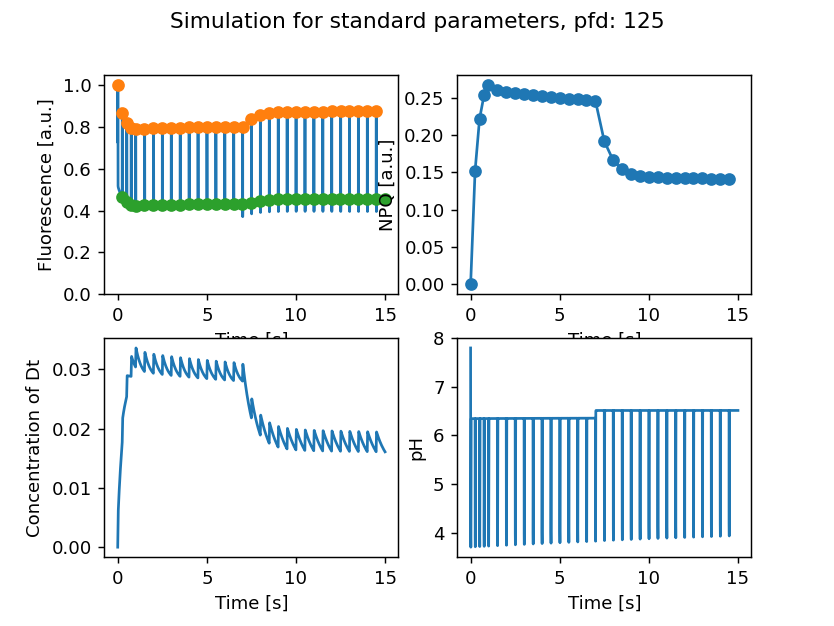

In [20]:
#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')

fig3 = plt.subplot(223)
plt.plot(s.get_time()/60., s.get_variable('Q'))
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s.get_time()/60., s.get_variable('pH'))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
plt.show()

<IPython.core.display.Javascript object>


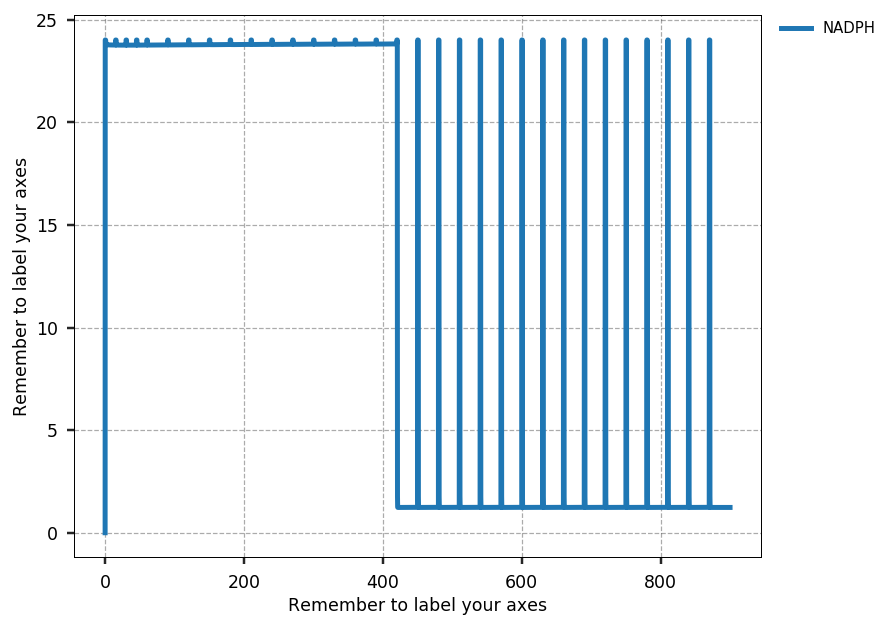

(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faead58b080>)

In [131]:
s.plot_selection('NADPH')

In [22]:
# keep the same colour palette
colpal = {'Mutant 1': 'limegreen',
          'Mutant I': 'limegreen',
          'Mutant 2': 'darkgreen',
          'Mutant G': 'darkgreen',
          'WT': 'red',
          'Overexpressor': 'darkcyan'}

<IPython.core.display.Javascript object>


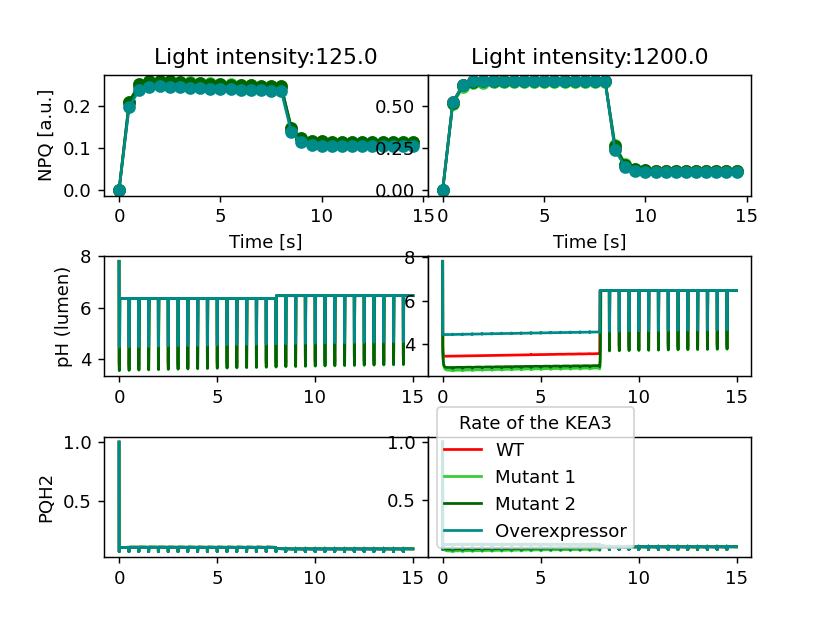

No handles with labels found to put in legend.


In [23]:
leak_var = {'WT': 100., 
            'Mutant 1': 1.,
            'Mutant 2': 10.,
            'Overexpressor': 1000.
           }

pfd_var = [125., 1200.]

dT = 30
Tmax=15*60
cnt = 0

fig, axs = plt.subplots(3, 2, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
axs[0].set_ylabel('NPQ [a.u.]')
axs[2].set_ylabel('pH (lumen)')
axs[4].set_ylabel('PQH2')



s = Simulator(m)
s.update_parameters({'gamma': 1.,
                     'kLeak': 100,
                    "kEpox": 0.05})

s.initialise(y0)
s.update_parameter('pfd', 0.)
s.simulate(1000)

y0d = s.get_variables(["PQ", "PC", "Fd", "E", "ATP", "NADPH", "H", 'Dd'])[-1]

s.initialise(y0d)


for light in pfd_var:
    axs[cnt].set_title('Light intensity:' + str(light))
    for leak in leak_var.keys():
        s = Simulator(m)
        s.initialise(y0d)
        s.update_parameters({'kLeak': leak_var[leak]
                            })

        t = 0.0
        while t < Tmax :   
            #turn on the saturating pulse of light of Tflash length
            if t%dT == 0:
                s.update_parameter('pfd', 10000)
                s.simulate(t+0.8)
            else:
                #switch on the light except for the dark period
                #t+dT-Tflash is the time to the next flash
                if t>8*60:
                    s.update_parameter('pfd', 50.)
                else:
                    #put the actinic light
                    s.update_parameter('pfd', light)
                new_t = t+dT-0.8
                s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
            t = s.get_time()[-1]   
        F = s.get_variable('Fluo')
        Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)

        #plt.plot(s.get_time(), F/max(F))
        #plt.plot(tm,Fm[0:]/max(F),'o')
        #plt.plot(to,Fo/max(F),'o')
        #plt.xticks(ticks=[0, 2*60, 4*60, 6*60, 8*60, 10*60, 12*60, 14*60], labels=[0,2,4,6,8,10,12,14])
        #plt.xlabel('Time [s]')
        #plt.ylabel('Fluorescence [a.u.]')
        
        axs[cnt].plot(tm/60., NPQ,'o-', label=leak, color=colpal[leak])
        axs[cnt].set_xlabel('Time [s]')


        axs[cnt+2].plot(s.get_time()/60., s.get_variable('pH'), label=leak, color=colpal[leak])

        axs[cnt+4].plot(s.get_time()/60., s.get_variable('PQ')/p['PQtot'], label=leak, color=colpal[leak])
        #plt.ylim(0,1)

    cnt+= 1
    plt.legend(title='Rate of the KEA3')
plt.show()

### Supplementary FigureS1 
Simulated temporal evolution of the plastoquinone redox state (red) and the antenna cross‐section of PSII (blue) as a response to light‐induced state transitions.

In [ ]:
plt.figure()
plt.plot(s.get_time(), s.get_variable('PQred')/s.model.get_parameter('PQtot'), 'r', label='reduced PQ')
plt.plot(s.get_time(), s.get_variable('ps2cs'), 'b', label='relative cross-section of PSII')

plt.xlabel('time [s]')
plt.yticks([0, 0.25, .5, .6, .7, .8, .9, 1],[0, 25, 50, 60, 70, 80, 90, 100])
plt.ylabel('% of the reduced PQ')
plt.legend()

## Reproduce PAM experiment (Fig 1. from the paper, lower pannel, anoxic conditions)

In [ ]:
# Simulation with switched off oxygen, not light
s = Simulator(m)

s.initialise(y0)
s.update_parameters({'pfd':0.001, 'ox': False, 'Ton': 270., 'Toff':900., 'dT': 90.})
                    
t=0
Tmax=1800
while t < Tmax :   
    #turn on the saturating pulse of light of Tflash length
    if t%s.model.get_parameter('dT') == 0:
        s.update_parameter('pfd', 5000)
        s.simulate(t+0.8, **{"atol":1.0e-10})
    else:
        s.update_parameter('pfd', 0.001)
        new_t = t+s.model.get_parameter('dT')-0.8
        s.simulate(new_t, **{"atol":1.0e-11})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]   

In [ ]:
# Needs to be normalized s.plot_selection('Fluo')
f = max(s.get_variable('Fluo'))
plt.figure()
plt.plot(s.get_time(), s.get_variable('Fluo')/f)
plt.xlabel('time [s]')
plt.ylim(0,1)
plt.ylabel('Fluorescence normalized to Fm')

In [ ]:
s.get_fluxes_df()